<a href="https://colab.research.google.com/github/czeacach/fashion_designers/blob/main/wdt_r%C3%A9seaux_relations_professionnelles_fashiondesigners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Relations réciproques entres personnes et avec les institutions

### ajouter parent organization? LVMH Kering
### ajouter les fashion journalist et fashion editor

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.core.display import display, HTML
import os

In [ ]:
!pip install itables
!pip install netgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.7/96.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.6/305.6 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 4.1 MB/s eta 0:00:00


In [ ]:
from itables import init_notebook_mode, show
from netgraph import Graph, InteractiveGraph

In [ ]:
!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 11.0 MB/s eta 0:00:00


In [ ]:
from pyvis.network import Network

## Production des données

Requête exécutée sur le serveur https://query.wikidata.org/
Propriétés prises en compte après inspection des propriétés de la population : educated at (2134) / member of (191)/ employer (421)



```
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>

SELECT DISTINCT ?item ?itemLabel (?year AS ?birthYear) ?r_property ?organisation ?organisationLabel ?coordinates
WHERE {
  {
    { ?item wdt:P106 wd:Q3501317 } # occupation is fashion designer.
    UNION
    { ?item wdt:P101 wd:Q29583 } # field of work is fashion design    
    ?item wdt:P31 wd:Q5; # Any instance of a human.
          wdt:P569 ?birthDate.
    BIND(REPLACE(str(?birthDate), "(.*)([0-9]{4})(.*)", "$2") AS ?year)
    FILTER(xsd:integer(?year) > 1800 && xsd:integer(?year) < 2001)

    {
      { ?item wdt:P463 ?organisation.
        BIND('member_of' AS ?r_property) }
      UNION  
      { ?item wdt:P69 ?organisation.
        BIND('educated_at' AS ?r_property) }
      UNION  
      { ?item wdt:P108 ?organisation.
        BIND('employer' AS ?r_property) }
    }
      
    OPTIONAL { ?organisation wdt:P625 ?coordinates }
    SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
  }
}
ORDER BY ?year

```



In [ ]:
### Ouvrir le fichier et créer un DataFrame
fd = '/content/drive/MyDrive/dossier de travail/wdt_analyse_reseaux.csv'
df = pd.read_csv(fd)
len(df)

2667

In [ ]:
### Ajouter deux périodes différentes en fonctions de la relation
# Pour la relation 'étudier' créer une période entre 18 et 28 ans (+17, +27) pour l'étendue des études
# Pour la relation 'employer' ajouté une période d'activité de 19 à 65 ans
df['YBegin'] = df[['birthYear', 'r_property']].apply(lambda x : int(x['birthYear'] + 17) if x['r_property'] == 'educated_at' else int(x['birthYear'] + 27), axis=1)
df['YEnd'] = df[['birthYear', 'r_property']].apply(lambda x : int(x['birthYear'] + 28) if x['r_property'] == 'employer' else int(x['birthYear'] + 64), axis=1)

In [ ]:
### Inspecter DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2667 entries, 0 to 2666
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   item               2667 non-null   object
 1   itemLabel          2667 non-null   object
 2   birthYear          2667 non-null   int64 
 3   r_property         2667 non-null   object
 4   organisation       2667 non-null   object
 5   organisationLabel  2667 non-null   object
 6   coordinates        2073 non-null   object
 7   YBegin             2667 non-null   int64 
 8   YEnd               2667 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 187.6+ KB


In [ ]:
### Inspecter la distribution des années de naissance
df.birthYear.describe()

count    2667.000000
mean     1958.931009
std        28.303821
min      1805.000000
25%      1945.000000
50%      1966.000000
75%      1980.000000
max      2000.000000
Name: birthYear, dtype: float64

In [ ]:
df.tail()

,item,itemLabel,birthYear,r_property,organisation,organisationLabel,coordinates,YBegin,YEnd
2662,http://www.wikidata.org/entity/Q118082384,Javi Guijarro,2000,employer,http://www.wikidata.org/entity/Q22001324,Karol G,NaN,2027,2028
2663,http://www.wikidata.org/entity/Q118082384,Javi Guijarro,2000,employer,http://www.wikidata.org/entity/Q25432114,Bad Gyal,NaN,2027,2028
2664,http://www.wikidata.org/entity/Q118082384,Javi Guijarro,2000,employer,http://www.wikidata.org/entity/Q61586861,Rauw Alejandro,NaN,2027,2028
2665,http://www.wikidata.org/entity/Q114051014,Giulia Frangiluna,2000,educated_at,http://www.wikidata.org/entity/Q5518,liceo classico,NaN,2017,2064
2666,http://www.wikidata.org/entity/Q118082384,Javi Guijarro,2000,educated_at,http://www.wikidata.org/entity/Q5397540,"Esdi, Escola Superior de Disseny",Point(2.1165 41.5436),2017,2064


In [ ]:
## intégrer la table dans la base de données --> ( table wdt_relations)
### nettoyer les données

# Beaucoup d'écoles/universités ont fusionné et changé de nom au cours du temps--> harmoniser avec un seul nom ?
#New York University < = New York University Institute of Fines Arts


In [ ]:
### Compter par propriété
df.groupby(by='r_property').size()

r_property
educated_at    2101
employer        377
member_of       189
dtype: int64

In [ ]:
organisations = df.groupby(by='organisationLabel').size()
show(organisations.sort_index(ascending=False))

In [ ]:
### Effectif total et les plus représentées
len(organisations), organisations.sort_values(ascending=False).head(10)

(1589,
 organisationLabel
 Parsons School of Design                       73
 Central Saint Martins                          61
 Fashion Institute of Technology                53
 Royal College of Art                           27
 Royal Academy of Fine Arts                     25
 London College of Fashion                      21
 Bunka Fashion College                          19
 Fashion Institute of Design & Merchandising    17
 Saint Martin's School of Art                   17
 Beaux-Arts de Paris                            13
 dtype: int64)

### Coder les périodes

In [ ]:
bins=[1801,1921,1971,2021]

In [ ]:
df['periode'] = pd.cut(df['birthYear'], bins=bins, right=False  )
df.periode = df.periode.apply( lambda x : str(x.left) + '_' + str(x.right))

In [ ]:
df.head()

,item,itemLabel,birthYear,r_property,organisation,organisationLabel,coordinates,YBegin,YEnd,periode
0,http://www.wikidata.org/entity/Q62128099,August Mannerheim,1805,employer,http://www.wikidata.org/entity/Q194060,Bank of Finland,NaN,1832,1833,1801_1921
1,http://www.wikidata.org/entity/Q5363058,Elizabeth Keckley,1818,employer,http://www.wikidata.org/entity/Q215062,Mary Todd Lincoln,NaN,1845,1846,1801_1921
2,http://www.wikidata.org/entity/Q64876982,John Redfern,1820,employer,http://www.wikidata.org/entity/Q7305826,Redfern,NaN,1847,1848,1801_1921
3,http://www.wikidata.org/entity/Q106151771,Madeleine Laferrière,1825,employer,http://www.wikidata.org/entity/Q3278826,Maison Laferrière,NaN,1852,1853,1801_1921
4,http://www.wikidata.org/entity/Q1255520,Alfred Isidore Römer,1832,educated_at,http://www.wikidata.org/entity/Q414052,"Academy of Fine Arts, Munich",Point(11.580312391 48.15319592),1849,1896,1801_1921


In [ ]:
### Effectif par période
df.groupby(by='periode').size()

periode
1801_1921     272
1921_1971    1266
1971_2021    1129
dtype: int64

In [ ]:
### Dataframe to dictionary
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_dict.html
ldf = df[['itemLabel', 'r_property', 'organisationLabel',
       'YBegin', 'YEnd', 'birthYear', 'periode']].sort_values(by='itemLabel').to_dict('records')

In [ ]:
ldf[:2]

[{'itemLabel': 'ASAP Bari',
  'r_property': 'member_of',
  'organisationLabel': 'ASAP Mob',
  'YBegin': 2018,
  'YEnd': 2055,
  'birthYear': 1991,
  'periode': '1971_2021'},
 {'itemLabel': 'Aarni Soivio',
  'r_property': 'educated_at',
  'organisationLabel': 'Sibelius Upper Secondary School',
  'YBegin': 2014,
  'YEnd': 2061,
  'birthYear': 1997,
  'periode': '1971_2021'}]

## Graphe à deux types de sommets

Il s'agit d'un graphe de type 'bipartite', cf. la documentation de Networkx:

https://networkx.org/documentation/stable/reference/algorithms/bipartite.html

Nous n'utilisons toutefois pas ici les fonctions spécifiques de Neworkx.

In [ ]:
l = []
for i in ldf:
    if i['periode'] == '1801_1921':
        l.append(tuple((i['itemLabel'],i['organisationLabel'],
                        {'relationship': i['r_property'], "birth_year": i['birthYear'], "periode": i['periode'] })))
l[:5]

[('Addie Masters',
  'Affiliated Fashionists',
  {'relationship': 'member_of', 'birth_year': 1901, 'periode': '1801_1921'}),
 ('Adele Filene',
  'Jantzen',
  {'relationship': 'employer', 'birth_year': 1909, 'periode': '1801_1921'}),
 ('Adele Filene',
  'Vogue Pattern Company',
  {'relationship': 'employer', 'birth_year': 1909, 'periode': '1801_1921'}),
 ('Adolf Dassler',
  'Adidas AG',
  {'relationship': 'employer', 'birth_year': 1900, 'periode': '1801_1921'}),
 ('Adrian',
  'Parsons School of Design',
  {'relationship': 'educated_at', 'birth_year': 1903, 'periode': '1801_1921'})]

In [ ]:
# Graphe Personne-Organisation
POG=nx.Graph()

In [ ]:
POG.add_edges_from(l)

In [ ]:
### Principales caractéristiques de ce graphe

POG.is_multigraph(), POG.is_directed(), nx.is_connected(POG), POG.number_of_nodes(), POG.number_of_edges(), nx.density(POG)

(False, False, False, 369, 263, 0.0038735713444090964)

In [ ]:
### Créer une liste des organisations
l_org = list(organisations.index); len(l_org); l_org[:6]

['1st State Duma of the Russian Federation',
 '20th Century Studios',
 '2nd State Duma of the Russian Federation',
 '3rd State Duma of the Russian Federation',
 '43 Group',
 'ABLF alumni network']

In [ ]:
list(POG.nodes.data())[:4]

[('Addie Masters', {}),
 ('Affiliated Fashionists', {}),
 ('Adele Filene', {}),
 ('Jantzen', {})]

In [ ]:
### Ajouter au sommets un code si personne ou organisation
# On utiliser pour ce faire la liste des organisations
types = {}
for e in list(POG.nodes):
    if e in l_org:
        t = 'O'
    else:
        t = 'P'
    types[e] = {'type': t}
[(k,v )for k,v in types.items()][:3]

[('Addie Masters', {'type': 'P'}),
 ('Affiliated Fashionists', {'type': 'O'}),
 ('Adele Filene', {'type': 'P'})]

In [ ]:
nx.set_node_attributes(POG, types)
list(POG.nodes.data())[:3]

[('Addie Masters', {'type': 'P'}),
 ('Affiliated Fashionists', {'type': 'O'}),
 ('Adele Filene', {'type': 'P'})]

## Inspecter les centralités de degré

" La centralité de degré repose sur le nombre de connexions directes que possède un nœud. Vous devez l’utiliser pour déterminer quels nœuds ont le plus d’influence directe. Par exemple, dans un réseau social, les utilisateurs qui ont le plus grand nombre de connexions bénéficient d’une centralité de degré plus élevée."

https://doc.arcgis.com/fr/insights/latest/analyze/link-analysis.htm#:~:text=La%20centralit%C3%A9%20de%20degr%C3%A9%20repose,centralit%C3%A9%20de%20degr%C3%A9%20plus%20%C3%A9lev%C3%A9e.

---



In [ ]:
### Ajouter la centralité de degré
# grâce à un dictionnaire construit selon le format souhaité
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(POG)])

In [ ]:
nx.set_node_attributes(POG, degree)

In [ ]:
print(list(POG.nodes.data())[:4])

[('Addie Masters', {'type': 'P', 'degree': 1}), ('Affiliated Fashionists', {'type': 'O', 'degree': 1}), ('Adele Filene', {'type': 'P', 'degree': 2}), ('Jantzen', {'type': 'O', 'degree': 1})]


In [ ]:
persons_degree = []
for n in list(POG.nodes.data()):
    if n[1]['type'] == 'P':
        persons_degree.append([n[0], n[1]['degree']])

In [ ]:
sorted(persons_degree, key = lambda x : x[1], reverse=True)[:10]

[['Russell Patterson', 14],
 ['Marie von Geldern-Egmond', 8],
 ['Siri Derkert', 7],
 ['Vera Mukhina', 7],
 ['Edith Head', 4],
 ['Heddi Hirsch', 4],
 ['Hugo Boss', 4],
 ['Jutta Sika', 4],
 ['Osceola Macarthy Adams', 4],
 ['Aili-Salli Ahde-Kjäldman', 3]]

In [ ]:
org_degree = []
for n in list(POG.nodes.data()):
    if n[1]['type'] == 'O':
        org_degree.append([n[0], n[1]['degree']])

In [ ]:
sorted(org_degree, key = lambda x : x[1], reverse=True)[:10]

[['Parsons School of Design', 8],
 ['Art Students League of New York', 6],
 ['University of Applied Arts Vienna', 6],
 ['Wiener Werkstätte', 6],
 ['Beaux-Arts de Paris', 5],
 ['Pratt Institute', 3],
 ['Académie de La Palette', 3],
 ['Académie de la Grande Chaumière', 3],
 ['Konstfack', 2],
 ['Deutscher Werkbund', 2]]

In [ ]:
edges = list(POG.edges.data())
edges[:5]

[('Addie Masters',
  'Affiliated Fashionists',
  {'relationship': 'member_of', 'birth_year': 1901, 'periode': '1801_1921'}),
 ('Adele Filene',
  'Jantzen',
  {'relationship': 'employer', 'birth_year': 1909, 'periode': '1801_1921'}),
 ('Adele Filene',
  'Vogue Pattern Company',
  {'relationship': 'employer', 'birth_year': 1909, 'periode': '1801_1921'}),
 ('Adolf Dassler',
  'Adidas AG',
  {'relationship': 'employer', 'birth_year': 1900, 'periode': '1801_1921'}),
 ('Adrian',
  'Parsons School of Design',
  {'relationship': 'educated_at', 'birth_year': 1903, 'periode': '1801_1921'})]

In [ ]:
labels = {}
for node in POG.nodes():
    labels[node] = node

In [ ]:
nx.set_node_attributes(POG, labels, 'label')

In [ ]:
nodes = list(POG.nodes.data())
nodes[:5]

[('Addie Masters', {'type': 'P', 'degree': 1, 'label': 'Addie Masters'}),
 ('Affiliated Fashionists',
  {'type': 'O', 'degree': 1, 'label': 'Affiliated Fashionists'}),
 ('Adele Filene', {'type': 'P', 'degree': 2, 'label': 'Adele Filene'}),
 ('Jantzen', {'type': 'O', 'degree': 1, 'label': 'Jantzen'}),
 ('Vogue Pattern Company',
  {'type': 'O', 'degree': 1, 'label': 'Vogue Pattern Company'})]

## Analyser les composantes du graphe
Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [ ]:
components = nx.connected_components(POG);
components_l = [len(c) for c in sorted(nx.connected_components(POG), key=len, reverse=True)]
len(components_l), components_l[:5]

(112, [44, 16, 15, 10, 10])

In [ ]:
S = [POG.subgraph(c).copy() for c in nx.connected_components(POG)]

In [ ]:
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True); ln[:8]

[[3, 44], [33, 16], [90, 15], [7, 10], [42, 10], [31, 7], [49, 5], [61, 5]]

In [ ]:
li=[n[0] for n in ln]

In [ ]:
S[21].nodes

NodeView(('Charles James', 'Harrow School'))

## Représenter le graphe

In [ ]:
u = S[14]

In [ ]:
u = nx.Graph()
for i in li[:5]:
    u = nx.union(u, S[i])
type(u)

networkx.classes.graph.Graph

In [ ]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

## ,nx.is_connected(G_1971_1975)
u.is_multigraph(), u.is_directed(), u.number_of_nodes(), u.number_of_edges(), nx.density(u)

(False, False, 95, 96, 0.021500559910414333)

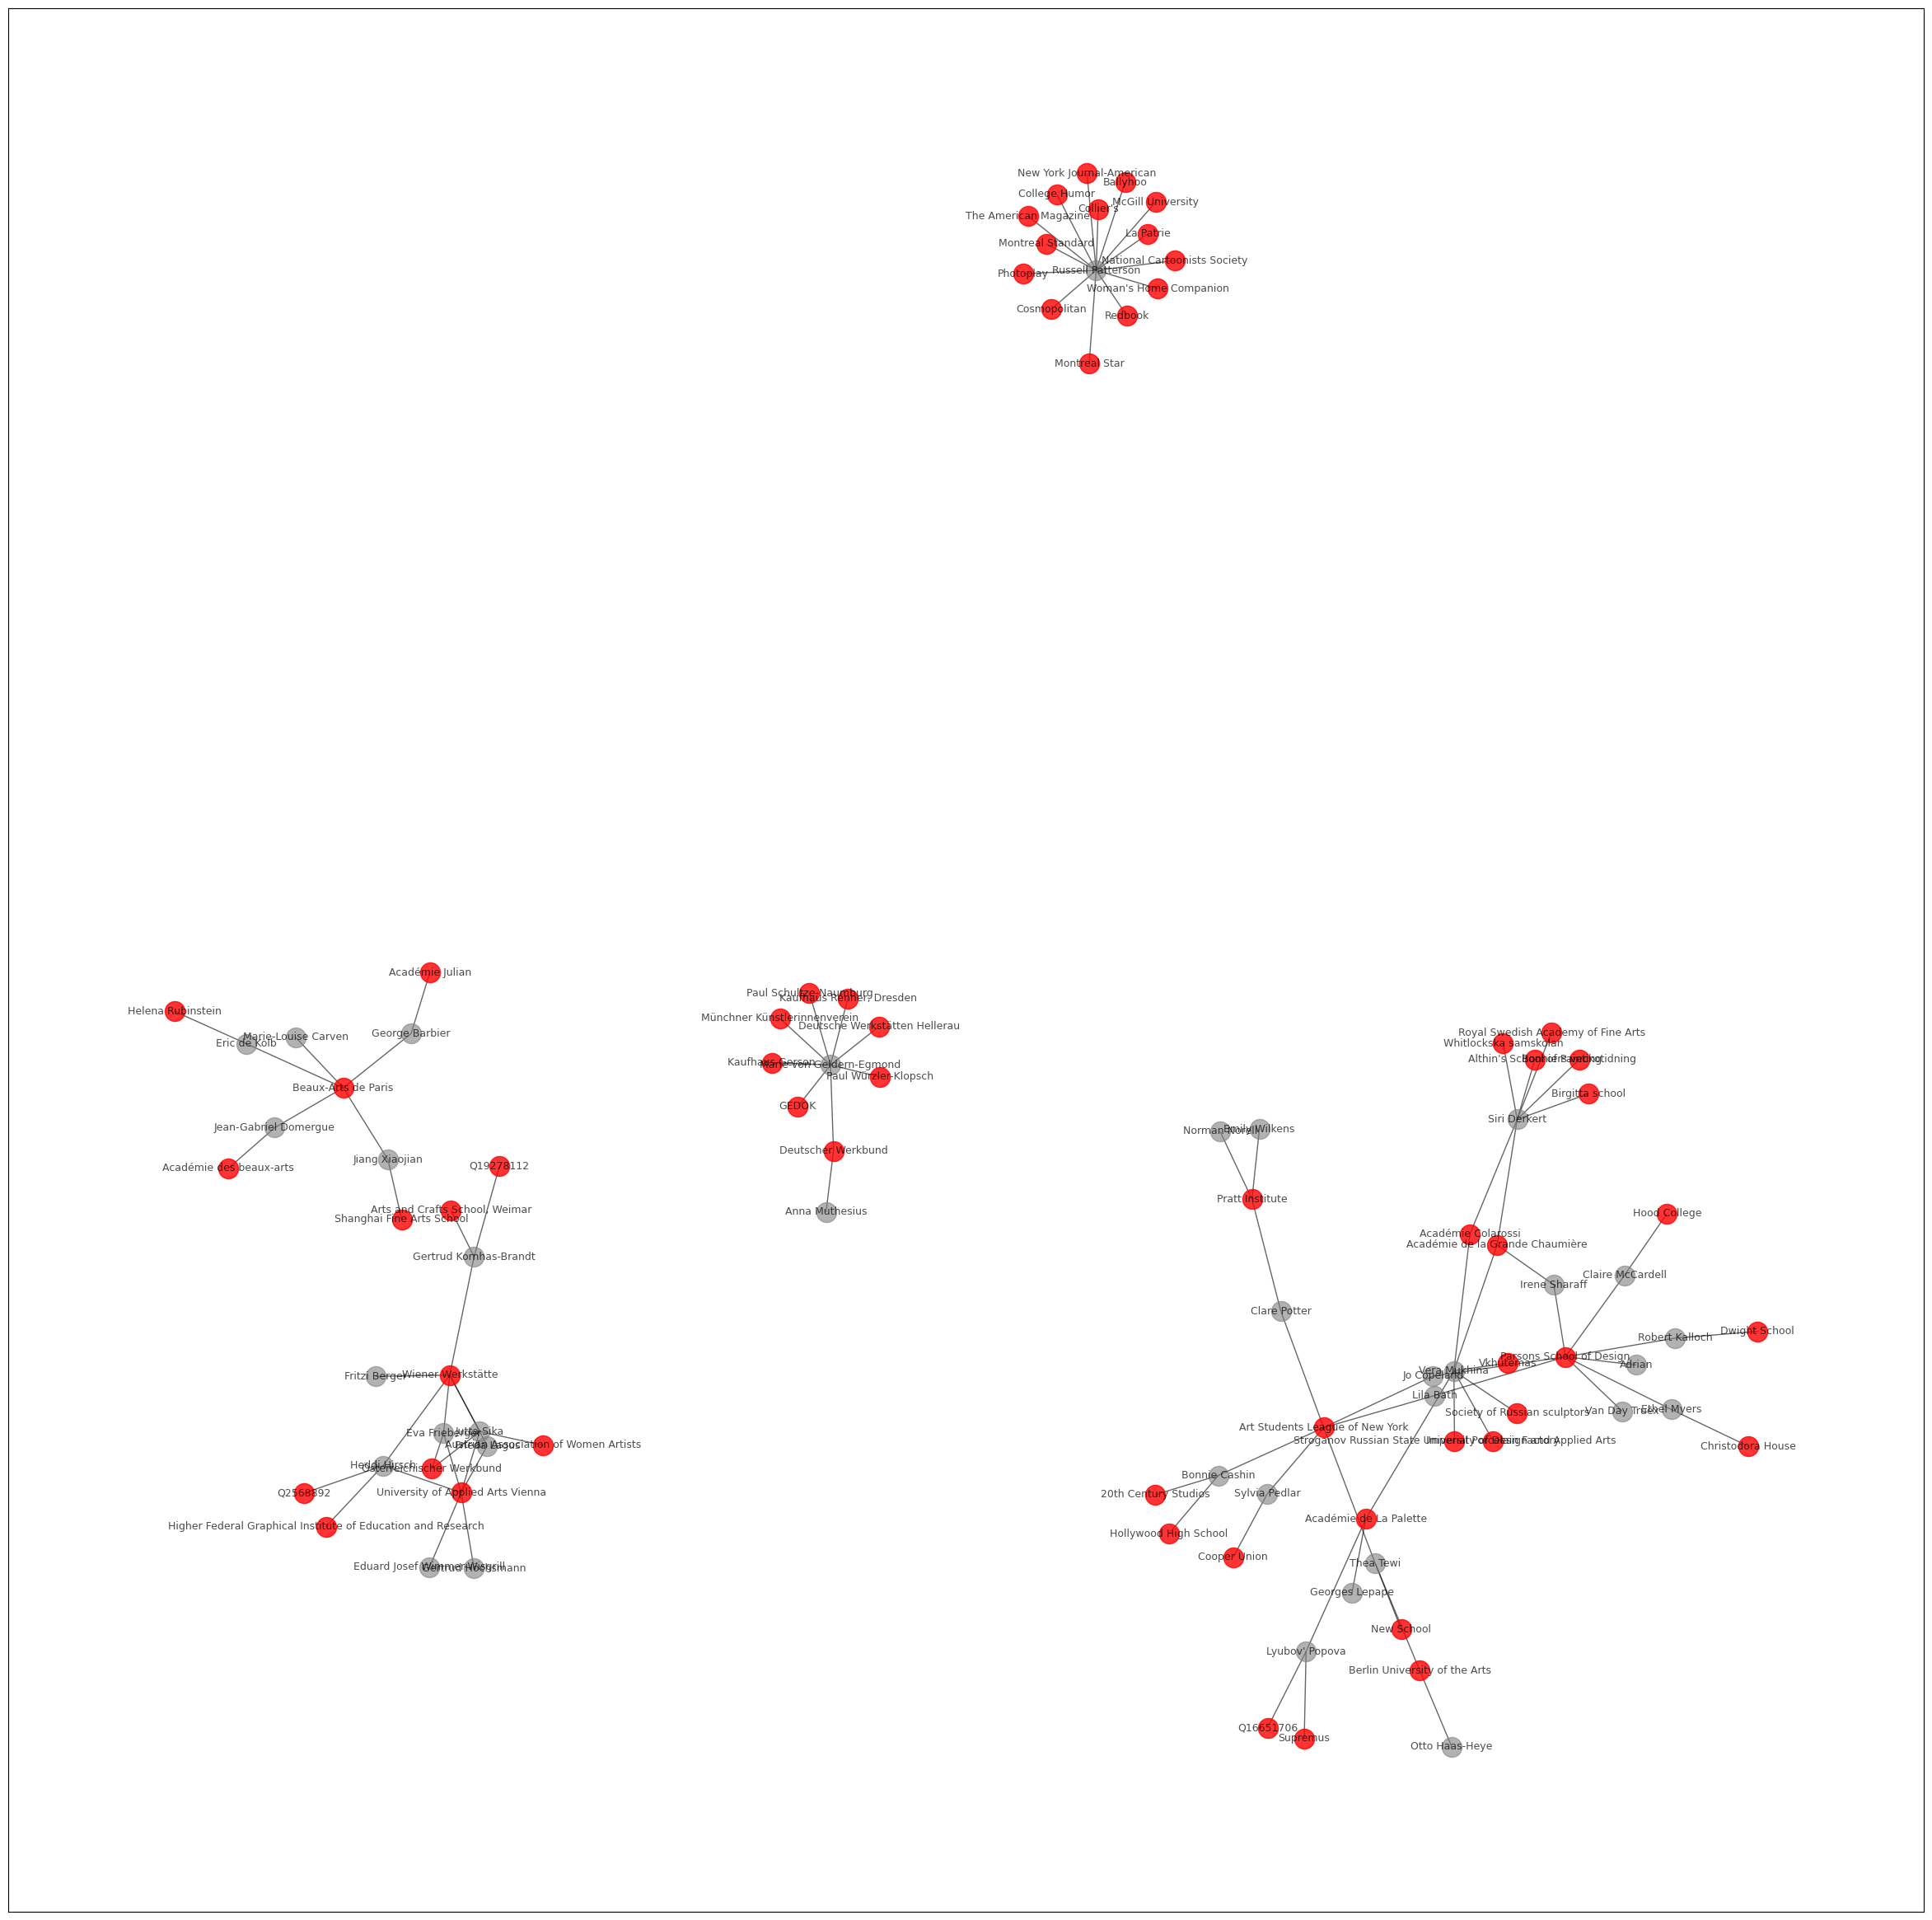

In [ ]:
### Visualiser l'ensemble des relations entre personnes et organisations (membres de / employé par ou étudié à)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (30,30))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g)

no = [x for x,y in g.nodes(data=True) if y['type']=='O']
np = [x for x,y in g.nodes(data=True) if y['type']=='P']

co = 'red'
cp = 'grey'
nx.draw_networkx_nodes(g, pos, nodelist=np, node_color=cp, alpha=0.6)
nx.draw_networkx_nodes(g, pos, nodelist=no, node_color=co, alpha=0.8)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c,
nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=9)


plt.show()

In [ ]:
###
# https://pyvis.readthedocs.io/en/latest/tutorial.html#using-pyvis-within-jupyter-notebook
nt = Network(notebook=True, cdn_resources='remote')
# populates the nodes and edges data structures
nt.from_nx(g)
nt.prep_notebook()
# Générer le fichier HTML contenant la visualisation
nt.show('pictures.html' )
display(HTML('pictures.html'))


pictures.html


### Créer les paires de personnes

Personnes ayant étudié dans la même université ou travaillé chez le même employeur à la même époque:

on teste si c'est la même université

on teste s'il y a superposition des périodes

In [ ]:
### Paires de personnes
pairs_p = []

for s1 in ldf:
    for s2 in ldf:
        if s1['itemLabel'] < s2['itemLabel'] \
            and s1['organisationLabel'] == s2['organisationLabel'] \
            and s2['YEnd'] > s1['YBegin'] \
            and s2['YBegin'] < s1['YEnd']:
            pairs_p.append([s1,s2])
        else:
            pass

In [ ]:
len(pairs_p)

7569

In [ ]:
pairs_p[:2]

[[{'itemLabel': 'Abderrahmane Trabsini',
   'r_property': 'educated_at',
   'organisationLabel': 'Royal Academy of Art',
   'YBegin': 2006,
   'YEnd': 2053,
   'birthYear': 1989,
   'periode': '1971_2021'},
  {'itemLabel': 'Hilde Sinke',
   'r_property': 'educated_at',
   'organisationLabel': 'Royal Academy of Art',
   'YBegin': 1992,
   'YEnd': 2039,
   'birthYear': 1975,
   'periode': '1971_2021'}],
 [{'itemLabel': 'Abderrahmane Trabsini',
   'r_property': 'educated_at',
   'organisationLabel': 'Royal Academy of Art',
   'YBegin': 2006,
   'YEnd': 2053,
   'birthYear': 1989,
   'periode': '1971_2021'},
  {'itemLabel': 'Lotte van Laatum',
   'r_property': 'educated_at',
   'organisationLabel': 'Royal Academy of Art',
   'YBegin': 1996,
   'YEnd': 2043,
   'birthYear': 1979,
   'periode': '1971_2021'}]]

### Créer les paires d'organisations
Une personne fait le lien entre deux organisations

In [ ]:
## Paires d'organisations
pairs_o = []

for s1 in ldf:
    for s2 in ldf:
        if s1['organisationLabel'] < s2['organisationLabel'] \
            and s1['itemLabel'] == s2['itemLabel']:
                pairs_o.append([s1,s2])
        else:
            pass

## Pairs d'organisations
pairs_o = []

for s1 in ldf:
    for s2 in ldf:
        if s1['target'] < s2['target'] \
            and s1['subject_uri'] == s2['subject_uri']:
                pairs_o.append([s1,s2])
        else:
            pass

In [ ]:
len(pairs_o)

2430

In [ ]:
### Apparaissent des parcours de vie
pairs_o[:2]

[[{'itemLabel': 'Aarni Soivio',
   'r_property': 'member_of',
   'organisationLabel': 'Kuumaa',
   'YBegin': 2024,
   'YEnd': 2061,
   'birthYear': 1997,
   'periode': '1971_2021'},
  {'itemLabel': 'Aarni Soivio',
   'r_property': 'educated_at',
   'organisationLabel': 'Sibelius Upper Secondary School',
   'YBegin': 2014,
   'YEnd': 2061,
   'birthYear': 1997,
   'periode': '1971_2021'}],
 [{'itemLabel': 'Abiodun Folashade Tokunbo',
   'r_property': 'educated_at',
   'organisationLabel': 'Lagos State University',
   'YBegin': 1997,
   'YEnd': 2044,
   'birthYear': 1980,
   'periode': '1971_2021'},
  {'itemLabel': 'Abiodun Folashade Tokunbo',
   'r_property': 'educated_at',
   'organisationLabel': 'The Polytechnic, Ibadan',
   'YBegin': 1997,
   'YEnd': 2044,
   'birthYear': 1980,
   'periode': '1971_2021'}]]

## Réseaux de personnes ayant étudié ou travaillé dans la même institution à la même époque (filtres, sous-populations)

In [ ]:
XIX_XX_pairs = [p for p in pairs_p if ((p[0]['periode']=='1801_1921') & (p[1]['periode']=='1801_1921'))]

In [ ]:
len(XIX_XX_pairs), XIX_XX_pairs[:3]

(98,
 [[{'itemLabel': 'Adrian',
    'r_property': 'educated_at',
    'organisationLabel': 'Parsons School of Design',
    'YBegin': 1920,
    'YEnd': 1967,
    'birthYear': 1903,
    'periode': '1801_1921'},
   {'itemLabel': 'Claire McCardell',
    'r_property': 'educated_at',
    'organisationLabel': 'Parsons School of Design',
    'YBegin': 1922,
    'YEnd': 1969,
    'birthYear': 1905,
    'periode': '1801_1921'}],
  [{'itemLabel': 'Adrian',
    'r_property': 'educated_at',
    'organisationLabel': 'Parsons School of Design',
    'YBegin': 1920,
    'YEnd': 1967,
    'birthYear': 1903,
    'periode': '1801_1921'},
   {'itemLabel': 'Ethel Myers',
    'r_property': 'educated_at',
    'organisationLabel': 'Parsons School of Design',
    'YBegin': 1898,
    'YEnd': 1945,
    'birthYear': 1881,
    'periode': '1801_1921'}],
  [{'itemLabel': 'Adrian',
    'r_property': 'educated_at',
    'organisationLabel': 'Parsons School of Design',
    'YBegin': 1920,
    'YEnd': 1967,
    'birthYear'

In [ ]:
almaMater_pairs = [p for p in pairs_p if ((p[0]['r_property'] == 'educated_at') & (p[1]['r_property'] == 'educated_at'))]

In [ ]:
len(almaMater_pairs), almaMater_pairs[:2]

(7201,
 [[{'itemLabel': 'Abderrahmane Trabsini',
    'r_property': 'educated_at',
    'organisationLabel': 'Royal Academy of Art',
    'YBegin': 2006,
    'YEnd': 2053,
    'birthYear': 1989,
    'periode': '1971_2021'},
   {'itemLabel': 'Hilde Sinke',
    'r_property': 'educated_at',
    'organisationLabel': 'Royal Academy of Art',
    'YBegin': 1992,
    'YEnd': 2039,
    'birthYear': 1975,
    'periode': '1971_2021'}],
  [{'itemLabel': 'Abderrahmane Trabsini',
    'r_property': 'educated_at',
    'organisationLabel': 'Royal Academy of Art',
    'YBegin': 2006,
    'YEnd': 2053,
    'birthYear': 1989,
    'periode': '1971_2021'},
   {'itemLabel': 'Lotte van Laatum',
    'r_property': 'educated_at',
    'organisationLabel': 'Royal Academy of Art',
    'YBegin': 1996,
    'YEnd': 2043,
    'birthYear': 1979,
    'periode': '1971_2021'}]])

## Exploration des graphes de personnes

### Période 1801-1921

In [ ]:
### Préparer pour créer le graphe
l = []
for i in XIX_XX_pairs: #personnes ayan étudié aux mêmes insitutions  pour la période 1801-1921
    l.append(tuple((i[0]['itemLabel'],i[1]['itemLabel'], {'relationship': f"{i[0]['r_property']}_{i[1]['r_property']}",
                                                              'organisation': i[0]['organisationLabel'] })))
l[:7]

[('Adrian',
  'Claire McCardell',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrian',
  'Ethel Myers',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrian',
  'Irene Sharaff',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrian',
  'Jo Copeland',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrian',
  'Lila Bath',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrian',
  'Robert Kalloch',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrian',
  'Van Day Truex',
  {'relationship': 'educated_at_employer',
   'organisation': 'Parsons School of Design'})]

In [ ]:
EMP=nx.Graph()

In [ ]:
EMP.add_edges_from(l)

In [ ]:
### Principales caractéristiques de ce graphe

EMP.is_multigraph(), EMP.is_directed(), nx.is_connected(EMP), EMP.number_of_nodes(), EMP.number_of_edges(), nx.density(EMP)

(False, False, False, 49, 86, 0.07312925170068027)

In [ ]:
nodes = list(EMP.nodes.data())
nodes[:5]

[('Adrian', {}),
 ('Claire McCardell', {}),
 ('Ethel Myers', {}),
 ('Irene Sharaff', {}),
 ('Jo Copeland', {})]

In [ ]:
edges = list(EMP.edges.data())
edges[:5]

[('Adrian',
  'Claire McCardell',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrian',
  'Ethel Myers',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrian',
  'Irene Sharaff',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrian',
  'Jo Copeland',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrian',
  'Lila Bath',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'})]

In [ ]:
labels = {}
for node in EMP.nodes():
    labels[node] = node

In [ ]:
###
# https://pyvis.readthedocs.io/en/latest/tutorial.html#using-pyvis-within-jupyter-notebook
# Créer un objet Network de PyVis avec l'option cdn_resources='remote'
nt = Network(notebook=True, cdn_resources='remote')
# populates the nodes and edges data structures
nt.from_nx(EMP)
nt.prep_notebook()
# Générer le fichier HTML contenant la visualisation
nt.show('graph.html')
display(HTML('graph.html'))


graph.html


### Analyser les composantes du graphe
Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [ ]:
nx.is_connected(EMP)

False

In [ ]:
# filtre qui va chercher les composantes qui sont connectées --> liste des composantes qui se trouve ds la variable component
components = nx.connected_components(EMP);
components_l = [len(c) for c in sorted(nx.connected_components(EMP), key=len, reverse=True)]
len(components_l), components_l[:5]
## résultat: 12 composantes

(12, [18, 8, 5, 2, 2])

In [ ]:
S = [EMP.subgraph(c).copy() for c in nx.connected_components(EMP)]
# création d'une liste des sous-graph

In [ ]:
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True); ln[:8]
#parcourir ces sous-graph et les "cuisiner"

[[0, 18], [5, 8], [6, 5], [1, 2], [2, 2], [3, 2], [4, 2], [7, 2]]

In [ ]:
li=[n[0] for n in ln]
## résultats dans l'ordre des effectifs


### Représenter le graphe

In [ ]:
u = nx.Graph()
for i in li[0:2]:
    u = nx.union(u, S[i])
type(u)

networkx.classes.graph.Graph

In [ ]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

## ,nx.is_connected(G_1971_1975)
u.is_multigraph(), u.is_directed(), u.number_of_nodes(), u.number_of_edges(), nx.density(u)

(False, False, 26, 67, 0.20615384615384616)

In [ ]:
u = S[5]

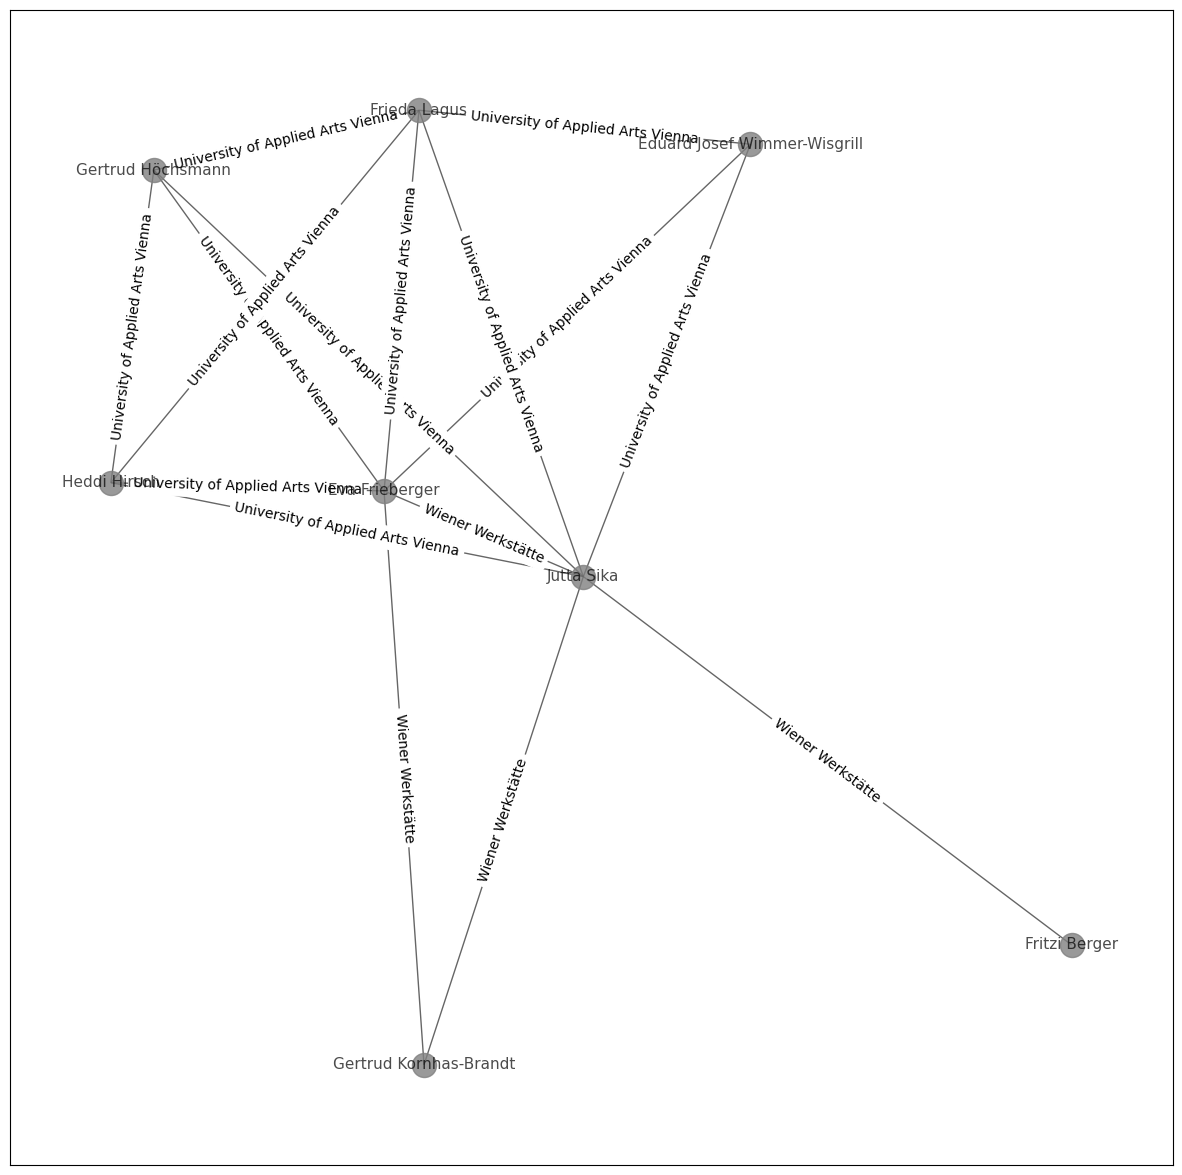

In [ ]:
# https://networkx.org/documentation/stable/reference/drawing.html
## enregistrer l'image save.html pour résoudre le problème

plt.figure(figsize = (15,15))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
### https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html

pos = nx.spring_layout(u, k=1)

labels = {e: u.get_edge_data(e[0], e[1])["organisation"] for e in u.edges()}

cp = 'grey'
nx.draw_networkx_nodes(g, pos, node_color=cp, alpha=0.8)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c,
nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=11)
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=labels)

# Vérification et création du répertoire 'images' si nécessaire
os.makedirs('images', exist_ok=True)

# Enregistrement de l'image
f_address = "images/XIX_XX_pairs_1.png"
plt.savefig(f_address)

# Affichage de l'image
plt.show()

### Période1921_1971

In [ ]:
early20_pairs = [p for p in pairs_p if ((p[0]['periode']=='1921_1971') & (p[1]['periode']=='1921_1971'))]

In [ ]:
### Préparer pour créer le graphe
l = []
for i in early20_pairs: #almaMater_pairs:
    l.append(tuple((i[0]['itemLabel'],i[1]['itemLabel'], {'relationship': f"{i[0]['r_property']}_{i[1]['r_property']}",
                                                              'organisation': i[0]['organisationLabel'] })))
l[:5]

[('Adrienne Steckling-Coen',
  'Alfred Sung',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrienne Steckling-Coen',
  'Anna Sui',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrienne Steckling-Coen',
  'Bill Blass',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrienne Steckling-Coen',
  'Carine Roitfeld',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrienne Steckling-Coen',
  'Christian Francis Roth',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'})]

In [ ]:
EMP=nx.Graph()

In [ ]:
EMP.add_edges_from(l)

In [ ]:
nodes = list(EMP.nodes.data())
nodes[:5]

[('Adrienne Steckling-Coen', {}),
 ('Alfred Sung', {}),
 ('Anna Sui', {}),
 ('Bill Blass', {}),
 ('Carine Roitfeld', {})]

In [ ]:
edges = list(EMP.edges.data())
edges[:5]

[('Adrienne Steckling-Coen',
  'Alfred Sung',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrienne Steckling-Coen',
  'Anna Sui',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrienne Steckling-Coen',
  'Bill Blass',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrienne Steckling-Coen',
  'Carine Roitfeld',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrienne Steckling-Coen',
  'Christian Francis Roth',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'})]

In [ ]:
labels = {}
for node in EMP.nodes():
    labels[node] = node

In [ ]:
###
# https://pyvis.readthedocs.io/en/latest/tutorial.html#using-pyvis-within-jupyter-notebook
# Créer un objet Network de PyVis avec l'option cdn_resources='remote'
nt = Network(notebook=True, cdn_resources='remote')
# populates the nodes and edges data structures
nt.from_nx(EMP)
nt.prep_notebook()
# Générer le fichier HTML contenant la visualisation
nt.show('graph1.html')
display(HTML('graph1.html'))

graph1.html


### Analyser les composantes du graphe
Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [ ]:
components = nx.connected_components(EMP);
components_l = [len(c) for c in sorted(nx.connected_components(EMP), key=len, reverse=True)]
len(components_l), components_l[:5]

(44, [220, 16, 16, 14, 11])

In [ ]:
S = [EMP.subgraph(c).copy() for c in nx.connected_components(EMP)]

In [ ]:
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True); ln[:8]

[[0, 220], [5, 16], [42, 16], [1, 14], [9, 11], [29, 8], [3, 7], [11, 7]]

In [ ]:
li=[n[0] for n in ln]

### Représenter le graphe

In [ ]:
u = nx.Graph()
for i in li[1:3]:
    u = nx.union(u, S[i])
type(u)

networkx.classes.graph.Graph

In [ ]:
u = S[5]

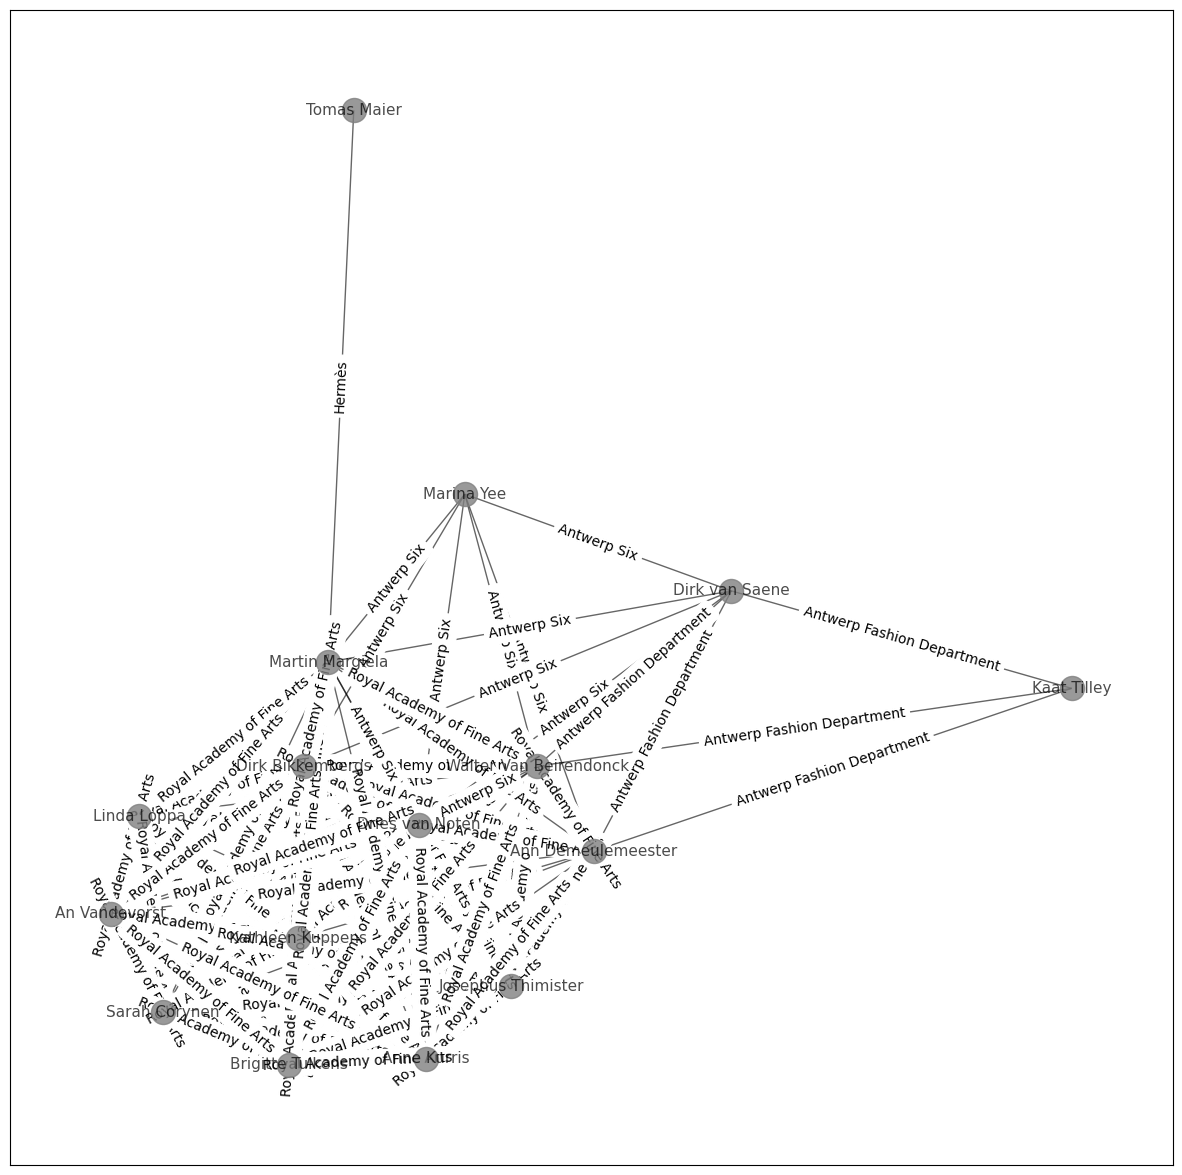

In [ ]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (15,15))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
### https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html

pos = nx.spring_layout(u, k=1)

labels = {e: u.get_edge_data(e[0], e[1])["organisation"] for e in u.edges()}

cp = 'grey'
nx.draw_networkx_nodes(g, pos, node_color=cp, alpha=0.8)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c,
nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=11)
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=labels)



plt.show()

## Explorer le graphe des organisations (relation Alma Mater)

In [ ]:
### Apparaissent des parcours de vie
pairs_o[:2]

[[{'itemLabel': 'Aarni Soivio',
   'r_property': 'member_of',
   'organisationLabel': 'Kuumaa',
   'YBegin': 2024,
   'YEnd': 2061,
   'birthYear': 1997,
   'periode': '1971_2021'},
  {'itemLabel': 'Aarni Soivio',
   'r_property': 'educated_at',
   'organisationLabel': 'Sibelius Upper Secondary School',
   'YBegin': 2014,
   'YEnd': 2061,
   'birthYear': 1997,
   'periode': '1971_2021'}],
 [{'itemLabel': 'Abiodun Folashade Tokunbo',
   'r_property': 'educated_at',
   'organisationLabel': 'Lagos State University',
   'YBegin': 1997,
   'YEnd': 2044,
   'birthYear': 1980,
   'periode': '1971_2021'},
  {'itemLabel': 'Abiodun Folashade Tokunbo',
   'r_property': 'educated_at',
   'organisationLabel': 'The Polytechnic, Ibadan',
   'YBegin': 1997,
   'YEnd': 2044,
   'birthYear': 1980,
   'periode': '1971_2021'}]]

In [ ]:
l = []
for i in pairs_o:
    if i[0]['r_property'] == 'educated_at' or  i[1]['r_property'] == 'educated_at':
        l.append(tuple((i[0]['organisationLabel'],i[1]['organisationLabel'], {'relationship': f"{i[0]['r_property']}_{i[1]['r_property']}",
                                                              'personne': i[0]['itemLabel'] })))
len(l), l[:3]

(1761,
 [('Kuumaa',
   'Sibelius Upper Secondary School',
   {'relationship': 'member_of_educated_at', 'personne': 'Aarni Soivio'}),
  ('Lagos State University',
   'The Polytechnic, Ibadan',
   {'relationship': 'educated_at_educated_at',
    'personne': 'Abiodun Folashade Tokunbo'}),
  ('Lagos State University',
   'The Polytechnic, Ibadan',
   {'relationship': 'educated_at_educated_at',
    'personne': 'Abiodun Folashade Tokunbo'})])

In [ ]:
### Graphe des organisation, liens AlmaMater

amO=nx.Graph()

In [ ]:
amO.add_edges_from(l)

In [ ]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

##amO.is_directed() ,nx.is_connected(G_1971_1975)
amO.is_multigraph(),nx.is_connected(amO) , amO.number_of_nodes(), amO.number_of_edges(), nx.density(amO)

(False, False, 1138, 1525, 0.002357203691767408)

In [ ]:
nodes = list(amO.nodes.data())
nodes[:5]

[('Kuumaa', {}),
 ('Sibelius Upper Secondary School', {}),
 ('Lagos State University', {}),
 ('The Polytechnic, Ibadan', {}),
 ('Cornell University', {})]

In [ ]:
edges = list(amO.edges.data())
edges[:5]

[('Kuumaa',
  'Sibelius Upper Secondary School',
  {'relationship': 'member_of_educated_at', 'personne': 'Aarni Soivio'}),
 ('Lagos State University',
  'The Polytechnic, Ibadan',
  {'relationship': 'educated_at_educated_at',
   'personne': 'Abiodun Folashade Tokunbo'}),
 ('Cornell University',
  'Nichols School',
  {'relationship': 'educated_at_educated_at', 'personne': 'Adam Lippes'}),
 ('Cornell University',
  'Gallatin School of Individualized Study',
  {'relationship': 'educated_at_educated_at', 'personne': 'Lynn Ban'}),
 ('Cornell University',
  'Agnes Irwin School',
  {'relationship': 'educated_at_educated_at', 'personne': 'Vanessa Noel'})]

### Analyser les composantes du graphe

Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [ ]:
components = nx.connected_components(amO);
components_l = [len(c) for c in sorted(nx.connected_components(amO), key=len, reverse=True)]
len(components_l), components_l[:5]

(187, [567, 23, 20, 18, 11])

In [ ]:
largest_cc = max(nx.connected_components(amO), key=len); type(largest_cc)

set

In [ ]:
S = amO.subgraph(largest_cc).copy()
type(S)

networkx.classes.graph.Graph

In [ ]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

##amO.is_directed() ,nx.is_connected(G_1971_1975)
S.is_multigraph(),nx.is_connected(S) , S.number_of_nodes(), S.number_of_edges(), nx.density(S)

(False, True, 567, 1030, 0.0064190052411489396)

### Centralité de degré

In [ ]:
# On construit ici le dictionnaire selon le format souhaité
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(S)])

In [ ]:
nx.set_node_attributes(amO, degree)
print(list(amO.nodes.data())[:3])

[('Kuumaa', {}), ('Sibelius Upper Secondary School', {}), ('Lagos State University', {})]


### Centralité de proximité

In [ ]:
closeness = nx.closeness_centrality(amO)

In [ ]:
nx.set_node_attributes(amO, closeness, 'closeness')
# print(G.nodes.data())

### Centralité d'intermédiarité

In [ ]:
betweenness = nx.betweenness_centrality(amO)

In [ ]:
nx.set_node_attributes(amO, betweenness, 'betweenness')

In [ ]:
### Exporter les attributs vers un DataFrame afin de les explorer
export = pd.DataFrame(amO.nodes.data(), columns = ['id', 'attributes'])
#export = export.set_index('id')
export.head()

,id,attributes
0,Kuumaa,"{'closeness': 0.0008795074758135445, 'betweenn..."
1,Sibelius Upper Secondary School,"{'closeness': 0.0008795074758135445, 'betweenn..."
2,Lagos State University,"{'closeness': 0.0008795074758135445, 'betweenn..."
3,"The Polytechnic, Ibadan","{'closeness': 0.0008795074758135445, 'betweenn..."
4,Cornell University,"{'degree': 3, 'closeness': 0.09115350919499315..."


In [ ]:
### Décomposer le champs attributs en colonnes
# https://stackoverflow.com/questions/38231591/split-explode-a-column-of-dictionaries-into-separate-columns-with-pandas

attributes = pd.json_normalize(export.attributes)

## Retour à affichage des décimales par défaut:
pd.options.display.float_format = '{: }'.format  # pour 4 chiffres : 4f


round(attributes, 4)

,closeness,betweenness,degree
0,0.0009,0.0,NaN
1,0.0009,0.0,NaN
2,0.0009,0.0,NaN
3,0.0009,0.0,NaN
4,0.0912,0.0017,3.0
...,...,...,...
1133,0.0009,0.0,NaN
1134,0.0009,0.0,NaN
1135,0.0012,0.0,NaN
1136,0.0009,0.0,NaN


In [ ]:
### appliquer au DataFrame et supprimer la colonne attributes
# en même temps mettre le nom en index
# export = export.join(pd.json_normalize(export.attributes)).set_index('id')
export = export.join(attributes)
export = export.drop(columns=['attributes'],axis=1)
export.head()

,id,closeness,betweenness,degree
0,Kuumaa,0.0008795074758135445,0.0,NaN
1,Sibelius Upper Secondary School,0.0008795074758135445,0.0,NaN
2,Lagos State University,0.0008795074758135445,0.0,NaN
3,"The Polytechnic, Ibadan",0.0008795074758135445,0.0,NaN
4,Cornell University,0.09115350919499315,0.0017481759510448798,3.0


In [ ]:
round(export.sort_values(by=['degree'], ascending=False).head(20),3)

,id,closeness,betweenness,degree
47,Parsons School of Design,0.158,0.081,65.0
42,Central Saint Martins,0.157,0.085,62.0
70,Fashion Institute of Technology,0.173,0.123,46.0
56,Royal College of Art,0.131,0.022,31.0
26,Fashion Institute of Design & Merchandising,0.126,0.014,18.0
135,Saint Martin's School of Art,0.142,0.02,17.0
156,Art Students League of New York,0.141,0.017,16.0
232,Beaux-Arts de Paris,0.095,0.007,16.0
108,New York University,0.139,0.009,16.0
23,Bunka Fashion College,0.083,0.011,14.0


In [ ]:
export['degree'].describe()
## permet de filter la population > la majorité des individu à un degré 4 ou moins ( 1,2,3)

count                567.0
mean       3.6331569664903
std      5.046724552472974
min                    1.0
25%                    1.0
50%                    2.0
75%                    4.0
max                   65.0
Name: degree, dtype: float64

In [ ]:
kamo = nx.k_core(amO, k=5)

In [ ]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

##amO.is_directed() ,nx.is_connected(G_1971_1975)
kamo.is_multigraph(),nx.is_connected(kamo) , kamo.number_of_nodes(), kamo.number_of_edges(), nx.density(kamo)

(False, False, 48, 151, 0.13386524822695037)

In [ ]:
components = nx.connected_components(kamo);
components_l = [len(c) for c in sorted(nx.connected_components(kamo), key=len, reverse=True)]
len(components_l), components_l[:5]

(4, [21, 15, 6, 6])

In [ ]:
largest_cc = max(nx.connected_components(kamo), key=len)

In [ ]:
new_cc = sorted(nx.connected_components(kamo), key=len, reverse=True)[1]


In [ ]:
S = kamo.subgraph(new_cc).copy()
type(S)

networkx.classes.graph.Graph

### Représenter le graphe

In [ ]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html
u = S
## ,nx.is_connected(G_1971_1975) u.is_directed(),
u.is_multigraph(), nx.is_connected(u), u.number_of_nodes(), u.number_of_edges(), nx.density(u)

(False, True, 15, 57, 0.5428571428571428)

In [ ]:
list(u.nodes.data())[1:3]

[('Otis College of Art and Design',
  {'degree': 13,
   'closeness': 0.1154735643121819,
   'betweenness': 0.016599249859381264}),
 ('Beaux-Arts de Paris',
  {'degree': 16,
   'closeness': 0.09509129156993718,
   'betweenness': 0.0069546567000950315})]

In [ ]:
labels = {}
for i in list(u.nodes.data()):
    if i[1]['degree'] >1:
        labels[i[0]]=i[0]
list(labels.items())[:3]

[('UCLA Lab School', 'UCLA Lab School'),
 ('Otis College of Art and Design', 'Otis College of Art and Design'),
 ('Beaux-Arts de Paris', 'Beaux-Arts de Paris')]

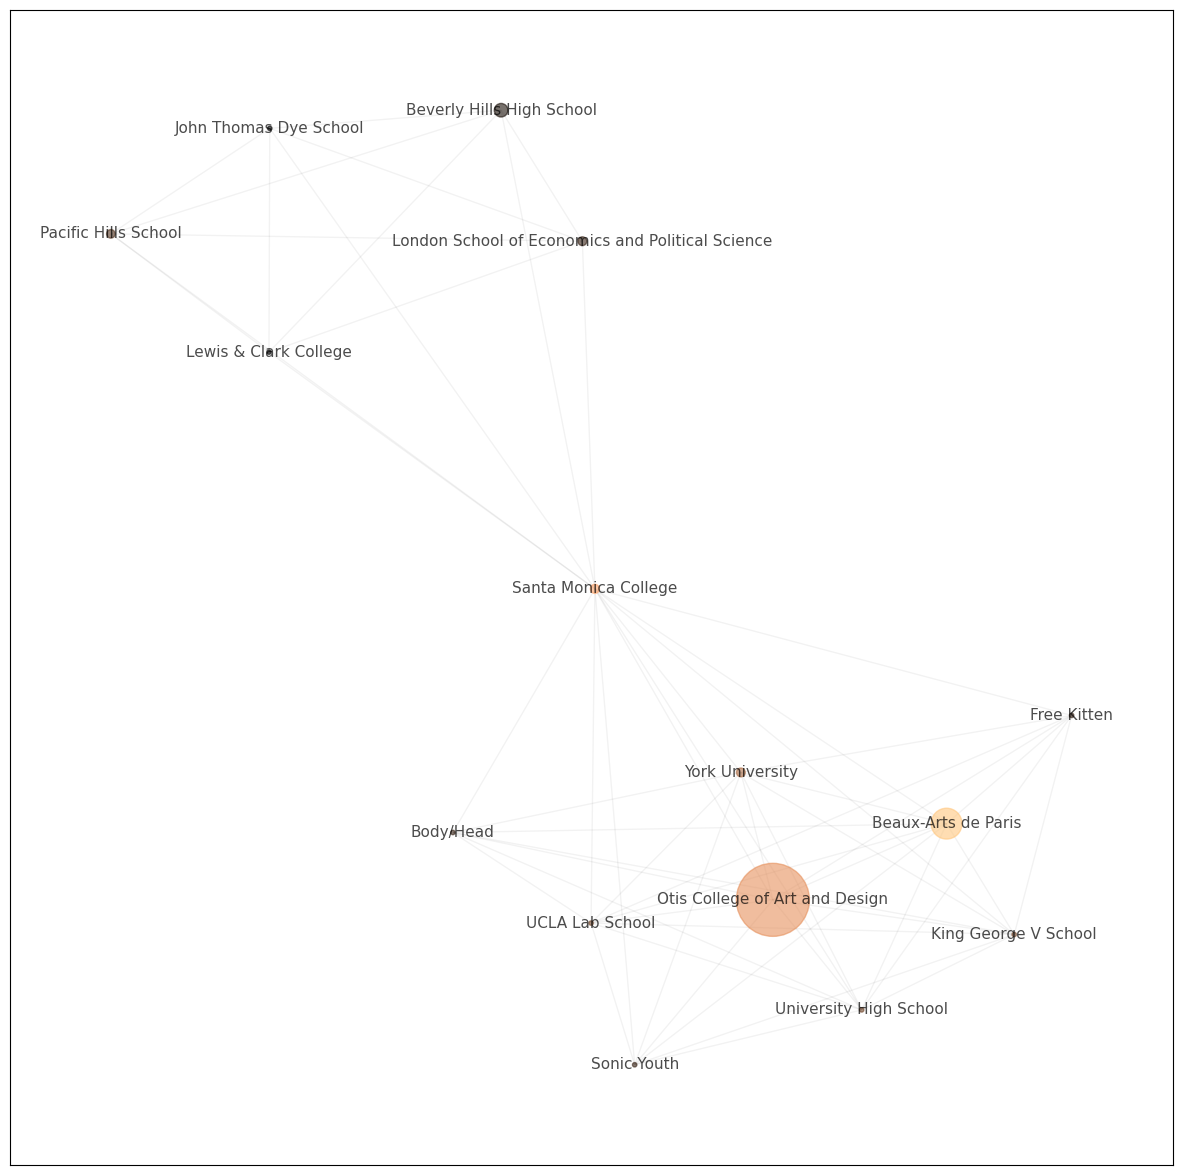

In [ ]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (15,15))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
### https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
pos = nx.spring_layout(g, k=1)

labels = {}
for i in list(u.nodes.data()):
    if i[1]['degree'] > 1:# degré filtre les résultats
        labels[i[0]]=i[0]

node_color = [i[1]['degree'] for i in list(u.nodes.data())]

### Adapter la taille des attribut à l'affichage
node_sizes = [i[1]['betweenness']**2 * 10000000 + 10 for i in list(u.nodes.data())] # visualisation de la taille


cp = 'grey'
nx.draw_networkx_nodes(g, pos, node_size=node_sizes, node_color=node_color,
                      cmap='copper', alpha=0.6)
nx.draw_networkx_edges(g, pos, alpha=0.05) # edgelist=ln, edge_color=c,
nx.draw_networkx_labels(g, pos, labels=labels,  alpha=0.7, font_size=11)
#nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=labels)

f = 'pictures/universites.svg'# io.BytesIO()

plt.show()